In [1]:
from IPython.display import display, HTML
from sympy.abc import alpha

display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# Brightway imports
import bw2analyzer as ba
import bw2calc as bc
import bw2data as bd
import bw2io as bi
import brightway2 as bw

In [3]:
import pandas as pd
import numpy as np
import datetime
import os

In [44]:
# Custom functions
from useful_functions import get_inventory_dataset, init_simple_lca, multi_lcia, multi_contribution_analysis, direct_technosphere_contribution_multi_activities_fixed,  calculate_projected_impacts
from visualisation_functions import plot_multilca_impacts, plot_contribution_analysis, plot_production_impacts, plot_incremental_impacts, plot_iwplus_contributions, plot_scenario_production_comparison, pie_charts_technosphere_contribution

# Set projects, LCI and LCIA methods

In [5]:
BW_PROJECT = 'regioinvent' # insert your project name here
bd.projects.set_current(BW_PROJECT)
bd.databases

Databases dictionary with 9 object(s):
	LIB raw materials
	Regioinvent
	biosphere3
	biosphere3_spatialized_flows
	cobalt
	ecoinvent-3.9.1-cutoff
	ecoinvent-3.9.1-cutoff regionalized
	graphite
	lithium

In [6]:
EI_DB = 'ecoinvent-3.9.1-cutoff'
RI_DB = 'Regioinvent'
LIB_RM_DB = 'LIB raw materials'

## Import LCI

In [7]:
# (mineral name: activity name, reference product, location)
INVENTORIES = {
    ## From EI
    "Neodymium":        ("rare earth oxides production, from rare earth carbonate concentrate", "neodymium oxide", "RoW"),
    "Copper concentrate, Canada": ('copper mine operation and beneficiation, sulfide ore', 'copper concentrate, sulfide ore', 'CA'),
    "Market for copper, cathode": ('market for copper, cathode', 'copper, cathode', 'GLO'),
    
    # From Istrate et al (2024)
    "Lithium hydroxide, brine":        ("lithium hydroxide production, Salar de Atacama", "lithium hydroxide, battery grade", "CL"),
    "Lithium hydroxide, spodumene":    ("lithium hydroxide production, from Australian spodumene", "lithium hydroxide, battery grade", "CN"),
    "Cobalt":                ("cobalt sulfate production, from copper-cobalt ore, economic allocation", "cobalt sulfate", "CN"),
    "Nickel":                ("nickel sulfate production, average excluding China, economic allocation", "nickel sulfate", "GLO"),
    "Graphite, natural":     ("natural graphite production, battery grade, from Heilongjiang", "natural graphite, battery grade", "CN"),
    "Graphite, synthetic":   ("graphite powder coating", "synthetic graphite, battery grade", "CN"),
    
    "Lithium carbonate, brine":        ("lithium carbonate production, Salar de Atacama", "lithium carbonate, battery grade", "CL"),
    "Lithium carbonate, spodumene":    ("lithium carbonate production, from Australian spodumene", "lithium carbonate, battery grade", "CN"),
}

In [8]:
INVENTORIES_EI = {
    "Neodymium": ("market for neodymium oxide", "neodymium oxide", "GLO"), # CAN not here
    "Copper": ("market for copper, cathode", "copper, cathode", 'GLO'),    
    "Lithium carbonate": ("market for lithium carbonate", "lithium carbonate", "GLO"),
    "Cobalt oxide": ("market for cobalt oxide", "cobalt oxide", "GLO"),
    "Nickel": ("market for nickel, class 1", "nickel, class 1", "GLO"),
    "Graphite": ("market for graphite, battery grade", "graphite, battery grade", "GLO")
}

In [9]:
# If we take consumption market activities 
# (mineral name: activity name, reference product, location)
INVENTORIES_RI = {
    "Neodymium": ("consumption market for neodymium oxide", "neodymium oxide", "US"), # CAN not here
    "Copper": ("consumption market for copper, cathode", "copper, cathode", 'CA'),    
    "Lithium carbonate": ("consumption market for lithium carbonate", "lithium carbonate", "CA"),
    "Cobalt oxide": ("consumption market for cobalt oxide", "cobalt oxide", "CA"),
    "Nickel": ("consumption market for nickel, class 1", "nickel, class 1", "CA"),
    "Graphite": ("consumption market for graphite, battery grade", "graphite, battery grade", "US"), # US     
}

In [10]:
INVENTORIES_EI_ds = get_inventory_dataset(INVENTORIES_EI, database_names=[EI_DB, LIB_RM_DB])

In [11]:
INVENTORIES_RI_ds = get_inventory_dataset(INVENTORIES_RI, database_names=[RI_DB])

## Pick LCIA methods

In [52]:
# We can also import some from IW+2.1
expert_ei39 = 'data/IW+2.1/impact_world_plus_21_brightway2_expert_version_ei39.6cd1745d7173fc689a3cc8c44fd3e41d.bw2package'
bw.BW2Package.import_file(expert_ei39)

[Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.9: Ecosystem quality: Climate change, ecosystem quality, long term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.9: Ecosystem quality: Climate change, ecosystem quality, short term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.9: Human health: Climate change, human health, long term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.9: Human health: Climate change, human health, short term,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.9: Midpoint: Climate change, long term,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.9: Midpoint: Climate change, short term,
 Brightway2 Method: IMPACT World+ Damage 2.1 for ecoinvent v3.9: Ecosystem quality: Fisheries impact,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.9: Midpoint: Fossil and nuclear energy use,
 Brightway2 Method: IMPACT World+ Midpoint 2.1 for ecoinvent v3.9: Midpoint: Fr

In [54]:
# Filter and display methods that contain "IMPACT World+" in their names
iw_methods = [method for method in bd.methods if "impact world+" in " ".join(method).lower()]
df_iw_methods = pd.DataFrame(iw_methods, columns=["Method", "Impact Category", "Subcategory"])
df_iw_methods.to_csv(r'data/IW+2.1/iw_methods.csv', index=False)

In [55]:
# To take them all
IMPACT_METHODS_ALL = {method[-1]: method for method in iw_methods}
IMPACT_METHODS_ALL

{'Climate change, ecosystem quality, long term': ('IMPACT World+ Damage 2.1 for ecoinvent v3.9',
  'Ecosystem quality',
  'Climate change, ecosystem quality, long term'),
 'Climate change, ecosystem quality, short term': ('IMPACT World+ Damage 2.1 for ecoinvent v3.9',
  'Ecosystem quality',
  'Climate change, ecosystem quality, short term'),
 'Climate change, human health, long term': ('IMPACT World+ Damage 2.1 for ecoinvent v3.9',
  'Human health',
  'Climate change, human health, long term'),
 'Climate change, human health, short term': ('IMPACT World+ Damage 2.1 for ecoinvent v3.9',
  'Human health',
  'Climate change, human health, short term'),
 'Climate change, long term': ('IMPACT World+ Midpoint 2.1 for ecoinvent v3.9',
  'Midpoint',
  'Climate change, long term'),
 'Climate change, short term': ('IMPACT World+ Midpoint 2.1 for ecoinvent v3.9',
  'Midpoint',
  'Climate change, short term'),
 'Marine acidification, long term': ('IMPACT World+ Damage 2.1 for ecoinvent v3.9',
  'E

In [17]:
IMPACT_METHODS = {
#'Climate change ST': ('IMPACT World+ Midpoint 2.0.1_regionalized','Midpoint', 'Climate change, short term'), 
'Total HH': ('IMPACT World+ Damage 2.1 for ecoinvent v3.9','Human health', 'Total human health'), 
'Total EQ': ('IMPACT World+ Damage 2.1 for ecoinvent v3.9','Ecosystem quality', 'Total ecosystem quality'), 
}


# Calculate specific impacts (e.g. per mass)

## With inventories from EI and other LCI

In [18]:
# Initialize LCA object
lca_ei = init_simple_lca(INVENTORIES_EI_ds["Neodymium"])

In [21]:
specific_lca_ei = {}
for rm in INVENTORIES_EI_ds:
    impacts = multi_lcia(lca_ei, INVENTORIES_EI_ds[rm], IMPACT_METHODS)
    specific_lca_ei[rm] = impacts

specific_lca_ei = pd.DataFrame(specific_lca_ei).T
specific_lca_ei = specific_lca_ei.reset_index().rename(columns={
    'index': 'Commodity',
})

In [22]:
specific_lca_ei

,Commodity,Total HH (DALY),Total EQ (PDF.m2.yr)
0,Neodymium,0.000494,113.360936
1,Copper,0.000283,50.940743
2,Lithium carbonate,0.000071,8.389314
3,Cobalt oxide,0.000609,38.463718
4,Nickel,0.000339,66.999634
5,Graphite,0.000014,1.686224


## With Regioinvent

In [23]:
# Initialize LCA object
lca_ri = init_simple_lca(INVENTORIES_RI_ds["Neodymium"])

In [24]:
specific_lca_ri = {}
for rm in INVENTORIES_RI_ds:
    impacts = multi_lcia(lca_ri, INVENTORIES_RI_ds[rm], IMPACT_METHODS)
    specific_lca_ri[rm] = impacts

specific_lca_ri = pd.DataFrame(specific_lca_ri).T
specific_lca_ri = specific_lca_ri.reset_index().rename(columns={
    'index': 'Commodity',
})

In [25]:
specific_lca_ri

,Commodity,Total HH (DALY),Total EQ (PDF.m2.yr)
0,Neodymium,0.000399,44.241839
1,Copper,0.000226,39.353087
2,Lithium carbonate,0.000052,5.126999
3,Cobalt oxide,0.000276,27.551156
4,Nickel,0.000119,36.382057
5,Graphite,0.000009,1.234363


## Plotting

Plot saved to results/specific_lca_results/lca_impacts_iw21_reg.png


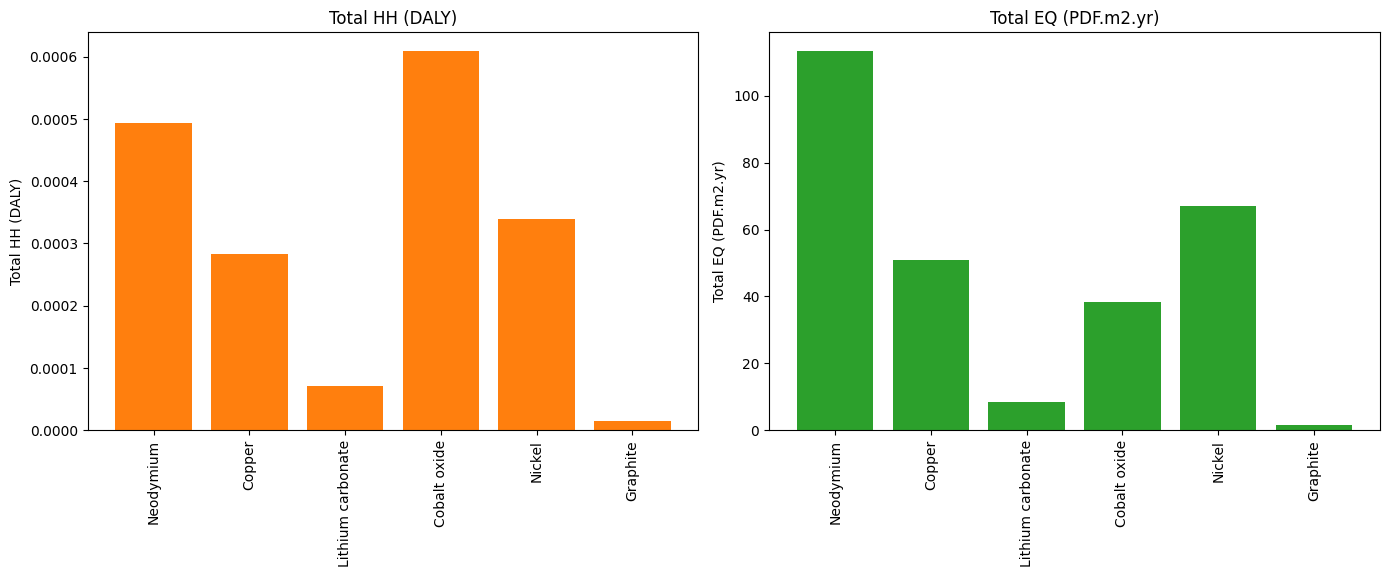

In [31]:
# Call the function
plot_multilca_impacts(specific_lca_ei, 
                 colors=["#ff7f0e", "#2ca02c"], 
                 save_path="results/specific_lca_results/lca_impacts_iw21_reg.png")

Plot saved to results/demand_lca_results/specific_lca_impacts_regioinvent.png


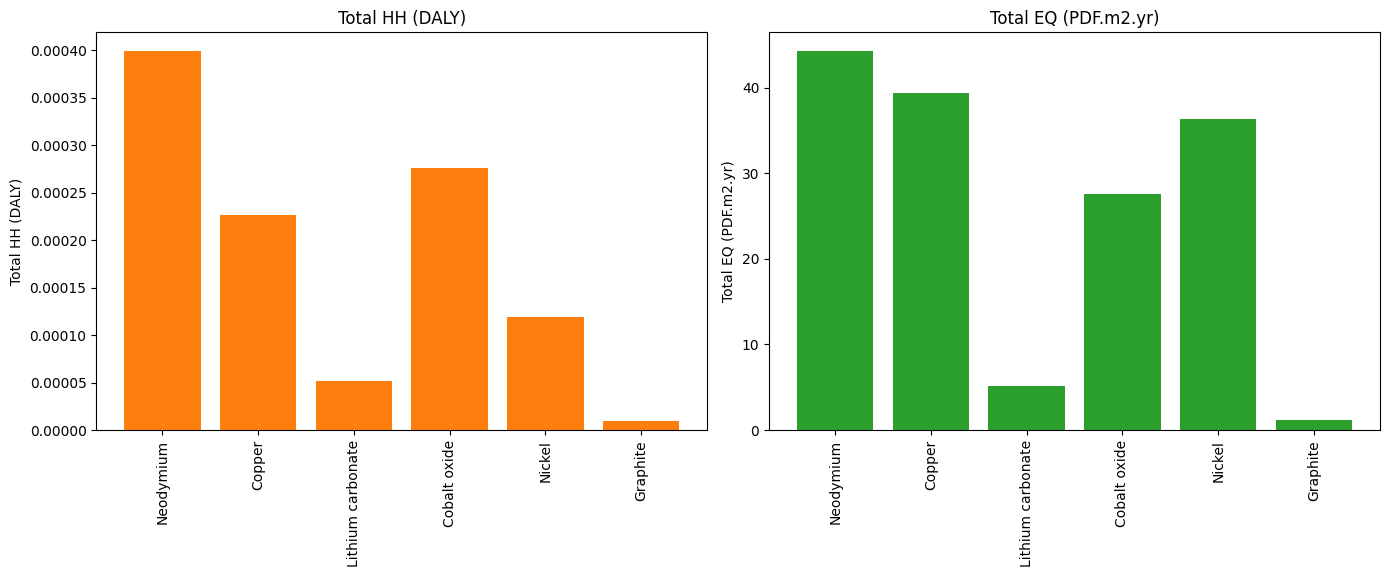

In [32]:
# Call the function
plot_multilca_impacts(specific_lca_ri, 
                 colors=["#ff7f0e", "#2ca02c"], 
                 save_path="results/demand_lca_results/specific_lca_impacts_regioinvent.png")

In [33]:
#specific_lca.to_csv(f"results/specific_lca_results/specific_results_{datetime.datetime.today().strftime('%d-%m-%Y')}.csv", index_label="Raw material")

## Contribution analysis

In [29]:
# Initialize a dictionary to store contribution results for each inventory
contribution_results = {}

# Loop through each inventory and perform contribution analysis
for rm_name, rm_ds in INVENTORIES_EI_ds.items():
    lca = init_simple_lca(rm_ds)
    contributions = multi_contribution_analysis(lca, IMPACT_METHODS, top_n=10, threshold=0.01)  # Set your threshold here
    contribution_results[rm_name] = contributions

# Convert the results into a more readable format for analysis
contribution_dfs = {}

for rm_name, impacts in contribution_results.items():
    for impact_name, contributions in impacts.items():
        df = pd.DataFrame(contributions)
        df["Inventory"] = rm_name
        df["Impact Category"] = impact_name
        contribution_dfs[(rm_name, impact_name)] = df

# Combine all individual DataFrames into one for easy viewing
contribution_analysis_df = pd.concat(contribution_dfs.values(), ignore_index=True)

# Set "Inventory" and "Impact Category" as the row indices
contribution_analysis_df.set_index(["Inventory", "Impact Category"], inplace=True)


In [30]:
contribution_analysis_df

score    quantity  percentage  \
Inventory Impact Category                                     
Neodymium Total HH         0.000074    1.067796   14.974419   
          Total HH         0.000033  794.418406    6.682477   
          Total HH         0.000017    1.316603    3.441054   
          Total HH         0.000016   16.027217    3.288408   
          Total HH         0.000016    0.116874    3.235759   
...                             ...         ...         ...   
Graphite  Total EQ         0.047280    0.017747    2.803904   
          Total EQ         0.031577    4.608683    1.872624   
          Total EQ         0.023998    0.164250    1.423199   
          Total EQ         0.022494    0.202884    1.334003   
          Total EQ         0.019276    0.233241    1.143156   

                                                                        name  \
Inventory Impact Category                                                      
Neodymium Total HH                                    citric acid production   
          Total HH                               water production, deionised   
          Total HH                                       zinc mine operation   
          Total HH         heat production, at hard coal industrial furna...   
          Total HH         electricity production, hard coal, at coal min...   
...                                                                      ...   
Graphite  Total EQ         electricity production, hard coal, at coal min...   
          Total EQ         transport, freight, sea, bulk carrier for dry ...   
          Total EQ                                  hard coal mine operation   
          Total EQ         heat production, at hard coal industrial furna...   
          Total EQ         hard coal mine operation and hard coal prepara...   

                                                           reference product  
Inventory Impact Category                                                     
Neodymium Total HH                                               citric acid  
          Total HH                                          water, deionised  
          Total HH                                          zinc concentrate  
          Total HH         heat, district or industrial, other than natur...  
          Total HH         electricity, high voltage, for internal use in...  
...                                                                      ...  
Graphite  Total EQ         electricity, high voltage, for internal use in...  
          Total EQ         transport, freight, sea, bulk carrier for dry ...  
          Total EQ                                    hard coal, run-of-mine  
          Total EQ         heat, district or industrial, other than natur...  
          Total EQ                                                 hard coal  

[110 rows x 5 columns]

In [42]:
# Example usage
inventory_names = ["Neodymium",
                   "Copper",
                   "Lithium carbonate", 
                   "Cobalt oxide",
                   "Nickel", 
                   "Graphite"
                   ]
plot_contribution_analysis(contribution_analysis_df, inventory_names,
                           colors=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"], 
                           save_path="results/specific_lca_results/contribution_analysis")

Plot saved to results/specific_lca_results/contribution_analysis
Plot saved to results/specific_lca_results/contribution_analysis
Plot saved to results/specific_lca_results/contribution_analysis
Plot saved to results/specific_lca_results/contribution_analysis
Plot saved to results/specific_lca_results/contribution_analysis
Plot saved to results/specific_lca_results/contribution_analysis


In [ ]:
#contribution_analysis_df.to_csv(f"results/specific_lca_results/contribution_analysis/contribution_analysis_{datetime.datetime.today().strftime('%d-%m-%Y')}.csv")

In [50]:
tech_contribution_df = direct_technosphere_contribution_multi_activities_fixed(lca_ri, activities=INVENTORIES_RI_ds, lcia_methods=IMPACT_METHODS, amount=1)

In [51]:
tech_contribution_df

,Activity,Flow Name,Flow Location,LCIA Method,Unit,Absolute Contribution,Percentage Contribution
0,Cobalt oxide,cobalt production,RoW,Total EQ,PDF.m2.yr,2.704730e+01,9.817120e+01
1,Cobalt oxide,cobalt production,CN,Total EQ,PDF.m2.yr,3.325495e-01,1.207026e+00
2,Cobalt oxide,cobalt production,BE,Total EQ,PDF.m2.yr,1.144417e-01,4.153791e-01
3,Cobalt oxide,"market group for transport, freight, lorry, un...",GLO,Total EQ,PDF.m2.yr,1.873176e-02,6.798900e-02
4,Cobalt oxide,"market group for transport, freight train",GLO,Total EQ,PDF.m2.yr,1.581790e-02,5.741285e-02
...,...,...,...,...,...,...,...
1099,Nickel,processing of nickel-rich materials,HK,Total HH,DALY,5.042957e-12,4.243258e-06
1100,Nickel,"treatment of metal part of electronics scrap, ...",CZ,Total HH,DALY,3.832070e-12,3.224390e-06
1101,Nickel,"treatment of metal part of electronics scrap, ...",IN,Total HH,DALY,2.153979e-12,1.812406e-06
1102,Nickel,"treatment of metal part of electronics scrap, ...",PL,Total HH,DALY,1.355820e-12,1.140818e-06


In [56]:
tech_contribution_df.to_csv(r'results/specific_lca_results/tech_contribution/tech_contribution.csv', index=False)

In [84]:
pie_charts_technosphere_contribution(tech_contribution_df, legend_size=12, percentage_threshold=5, save_path='results/specific_lca_results/tech_contribution_analysis')

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_15216\2493178880.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Saved: results/specific_lca_results/tech_contribution_analysis/Cobalt_oxide_Total_EQ_pie_chart.html


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_15216\2493178880.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Saved: results/specific_lca_results/tech_contribution_analysis/Cobalt_oxide_Total_HH_pie_chart.html


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_15216\2493178880.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\mp_ma\AppData\Local\Temp\ipykernel_15216\2493178880.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Saved: results/specific_lca_results/tech_contribution_analysis/Copper_Total_EQ_pie_chart.html


Saved: results/specific_lca_results/tech_contribution_analysis/Copper_Total_HH_pie_chart.html


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_15216\2493178880.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\mp_ma\AppData\Local\Temp\ipykernel_15216\2493178880.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Saved: results/specific_lca_results/tech_contribution_analysis/Graphite_Total_EQ_pie_chart.html


Saved: results/specific_lca_results/tech_contribution_analysis/Graphite_Total_HH_pie_chart.html


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_15216\2493178880.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Saved: results/specific_lca_results/tech_contribution_analysis/Lithium_carbonate_Total_EQ_pie_chart.html


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_15216\2493178880.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Saved: results/specific_lca_results/tech_contribution_analysis/Lithium_carbonate_Total_HH_pie_chart.html


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_15216\2493178880.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Saved: results/specific_lca_results/tech_contribution_analysis/Neodymium_Total_EQ_pie_chart.html


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_15216\2493178880.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Saved: results/specific_lca_results/tech_contribution_analysis/Neodymium_Total_HH_pie_chart.html


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_15216\2493178880.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Saved: results/specific_lca_results/tech_contribution_analysis/Nickel_Total_EQ_pie_chart.html


C:\Users\mp_ma\AppData\Local\Temp\ipykernel_15216\2493178880.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Saved: results/specific_lca_results/tech_contribution_analysis/Nickel_Total_HH_pie_chart.html


In [76]:
# Filter to remove midpoint indicators and footprint entries
IMPACT_METHODS_DAMAGE = {
    key: value for key, value in IMPACT_METHODS_ALL.items()
    if value[1] != "Midpoint" and value[0] == "IMPACT World+ Damage 2.1 for ecoinvent v3.9"
}

In [77]:
IMPACT_METHODS_DAMAGE

{'Climate change, ecosystem quality, long term': ('IMPACT World+ Damage 2.1 for ecoinvent v3.9',
  'Ecosystem quality',
  'Climate change, ecosystem quality, long term'),
 'Climate change, ecosystem quality, short term': ('IMPACT World+ Damage 2.1 for ecoinvent v3.9',
  'Ecosystem quality',
  'Climate change, ecosystem quality, short term'),
 'Climate change, human health, long term': ('IMPACT World+ Damage 2.1 for ecoinvent v3.9',
  'Human health',
  'Climate change, human health, long term'),
 'Climate change, human health, short term': ('IMPACT World+ Damage 2.1 for ecoinvent v3.9',
  'Human health',
  'Climate change, human health, short term'),
 'Marine acidification, long term': ('IMPACT World+ Damage 2.1 for ecoinvent v3.9',
  'Ecosystem quality',
  'Marine acidification, long term'),
 'Marine acidification, short term': ('IMPACT World+ Damage 2.1 for ecoinvent v3.9',
  'Ecosystem quality',
  'Marine acidification, short term'),
 'Freshwater ecotoxicity, short term': ('IMPACT Wo

In [65]:
specific_lca_damage = {}
for rm in INVENTORIES_EI_ds:
    impacts = multi_lcia(lca_ei, INVENTORIES_EI_ds[rm], IMPACT_METHODS_DAMAGE)
    specific_lca_damage[rm] = impacts

specific_lca_damage = pd.DataFrame(specific_lca_damage).T
specific_lca_damage = specific_lca_damage.reset_index().rename(columns={
    'index': 'Commodity'
})

In [66]:
specific_lca_damage

,"Climate change, ecosystem quality, long term (PDF.m2.yr)","Climate change, ecosystem quality, short term (PDF.m2.yr)","Climate change, human health, long term (DALY)","Climate change, human health, short term (DALY)","Marine acidification, long term (PDF.m2.yr)","Marine acidification, short term (PDF.m2.yr)","Freshwater ecotoxicity, short term (PDF.m2.yr)","Human toxicity cancer, short term (DALY)","Human toxicity non-cancer, short term (DALY)","Freshwater ecotoxicity, long term (PDF.m2.yr)",...,Total ecosystem quality (PDF.m2.yr),Fisheries impact (PDF.m2.yr),"Ionizing radiations, ecosystem quality (PDF.m2.yr)","Ionizing radiations, human health (DALY)","Marine ecotoxicity, long term (PDF.m2.yr)","Marine ecotoxicity, short term (PDF.m2.yr)","Photochemical ozone formation, ecosystem quality (PDF.m2.yr)","Photochemical ozone formation, human health (DALY)","Terrestrial ecotoxicity, long term (PDF.m2.yr)","Terrestrial ecotoxicity, short term (PDF.m2.yr)"
Neodymium,20.399825,6.305916,0.000275,0.000085,7.330516,0.795741,1.954304,2.344109e-05,3.034820e-05,18.771837,...,113.360936,1.258065e-16,1.920807e-07,1.092273e-06,5.601740e-05,4.522460e-05,1.545670,1.572063e-07,2.044755,1.650698
Copper,2.594694,0.798194,0.000035,0.000011,0.926504,0.100574,0.741511,1.185854e-05,9.415774e-05,23.917900,...,50.940743,3.316963e-18,1.488563e-09,1.923115e-08,1.944593e-04,1.481555e-04,0.586658,5.995363e-08,7.097788,5.407678
Lithium carbonate,2.894554,0.885413,0.000039,0.000012,1.043821,0.113309,0.325898,1.773585e-06,2.828763e-06,1.096343,...,8.389314,1.016205e-17,5.175482e-10,8.292738e-09,4.012310e-06,3.473769e-06,0.249542,2.540666e-08,0.146450,0.126793
Cobalt oxide,12.331353,3.804674,0.000166,0.000051,4.193570,0.455221,1.197473,9.419706e-06,1.252682e-05,7.051624,...,38.463718,1.518202e-17,5.976596e-08,5.816918e-07,2.506587e-05,1.834518e-05,0.800839,7.909261e-08,0.914923,0.669599
Nickel,6.542067,2.022925,0.000088,0.000027,2.406499,0.261212,1.101279,3.998047e-06,3.841162e-06,17.536313,...,66.999634,5.485089e-18,1.231409e-08,1.234070e-07,1.485894e-04,1.057421e-04,0.719222,7.279142e-08,5.423518,3.859587
Graphite,0.500656,0.182539,0.000007,0.000002,0.180186,0.019559,0.164704,5.148306e-07,9.234675e-08,0.344017,...,1.686224,1.039673e-19,2.332993e-10,3.508050e-09,7.872248e-08,6.026078e-08,0.074134,6.453628e-09,0.002873,0.002200


In [36]:
#specific_lca_damage.to_csv(f"results/specific_lca_results/specific_results_hh_eq{datetime.datetime.today().strftime#'%d-%m-%Y')}.csv", index_label="Raw material")

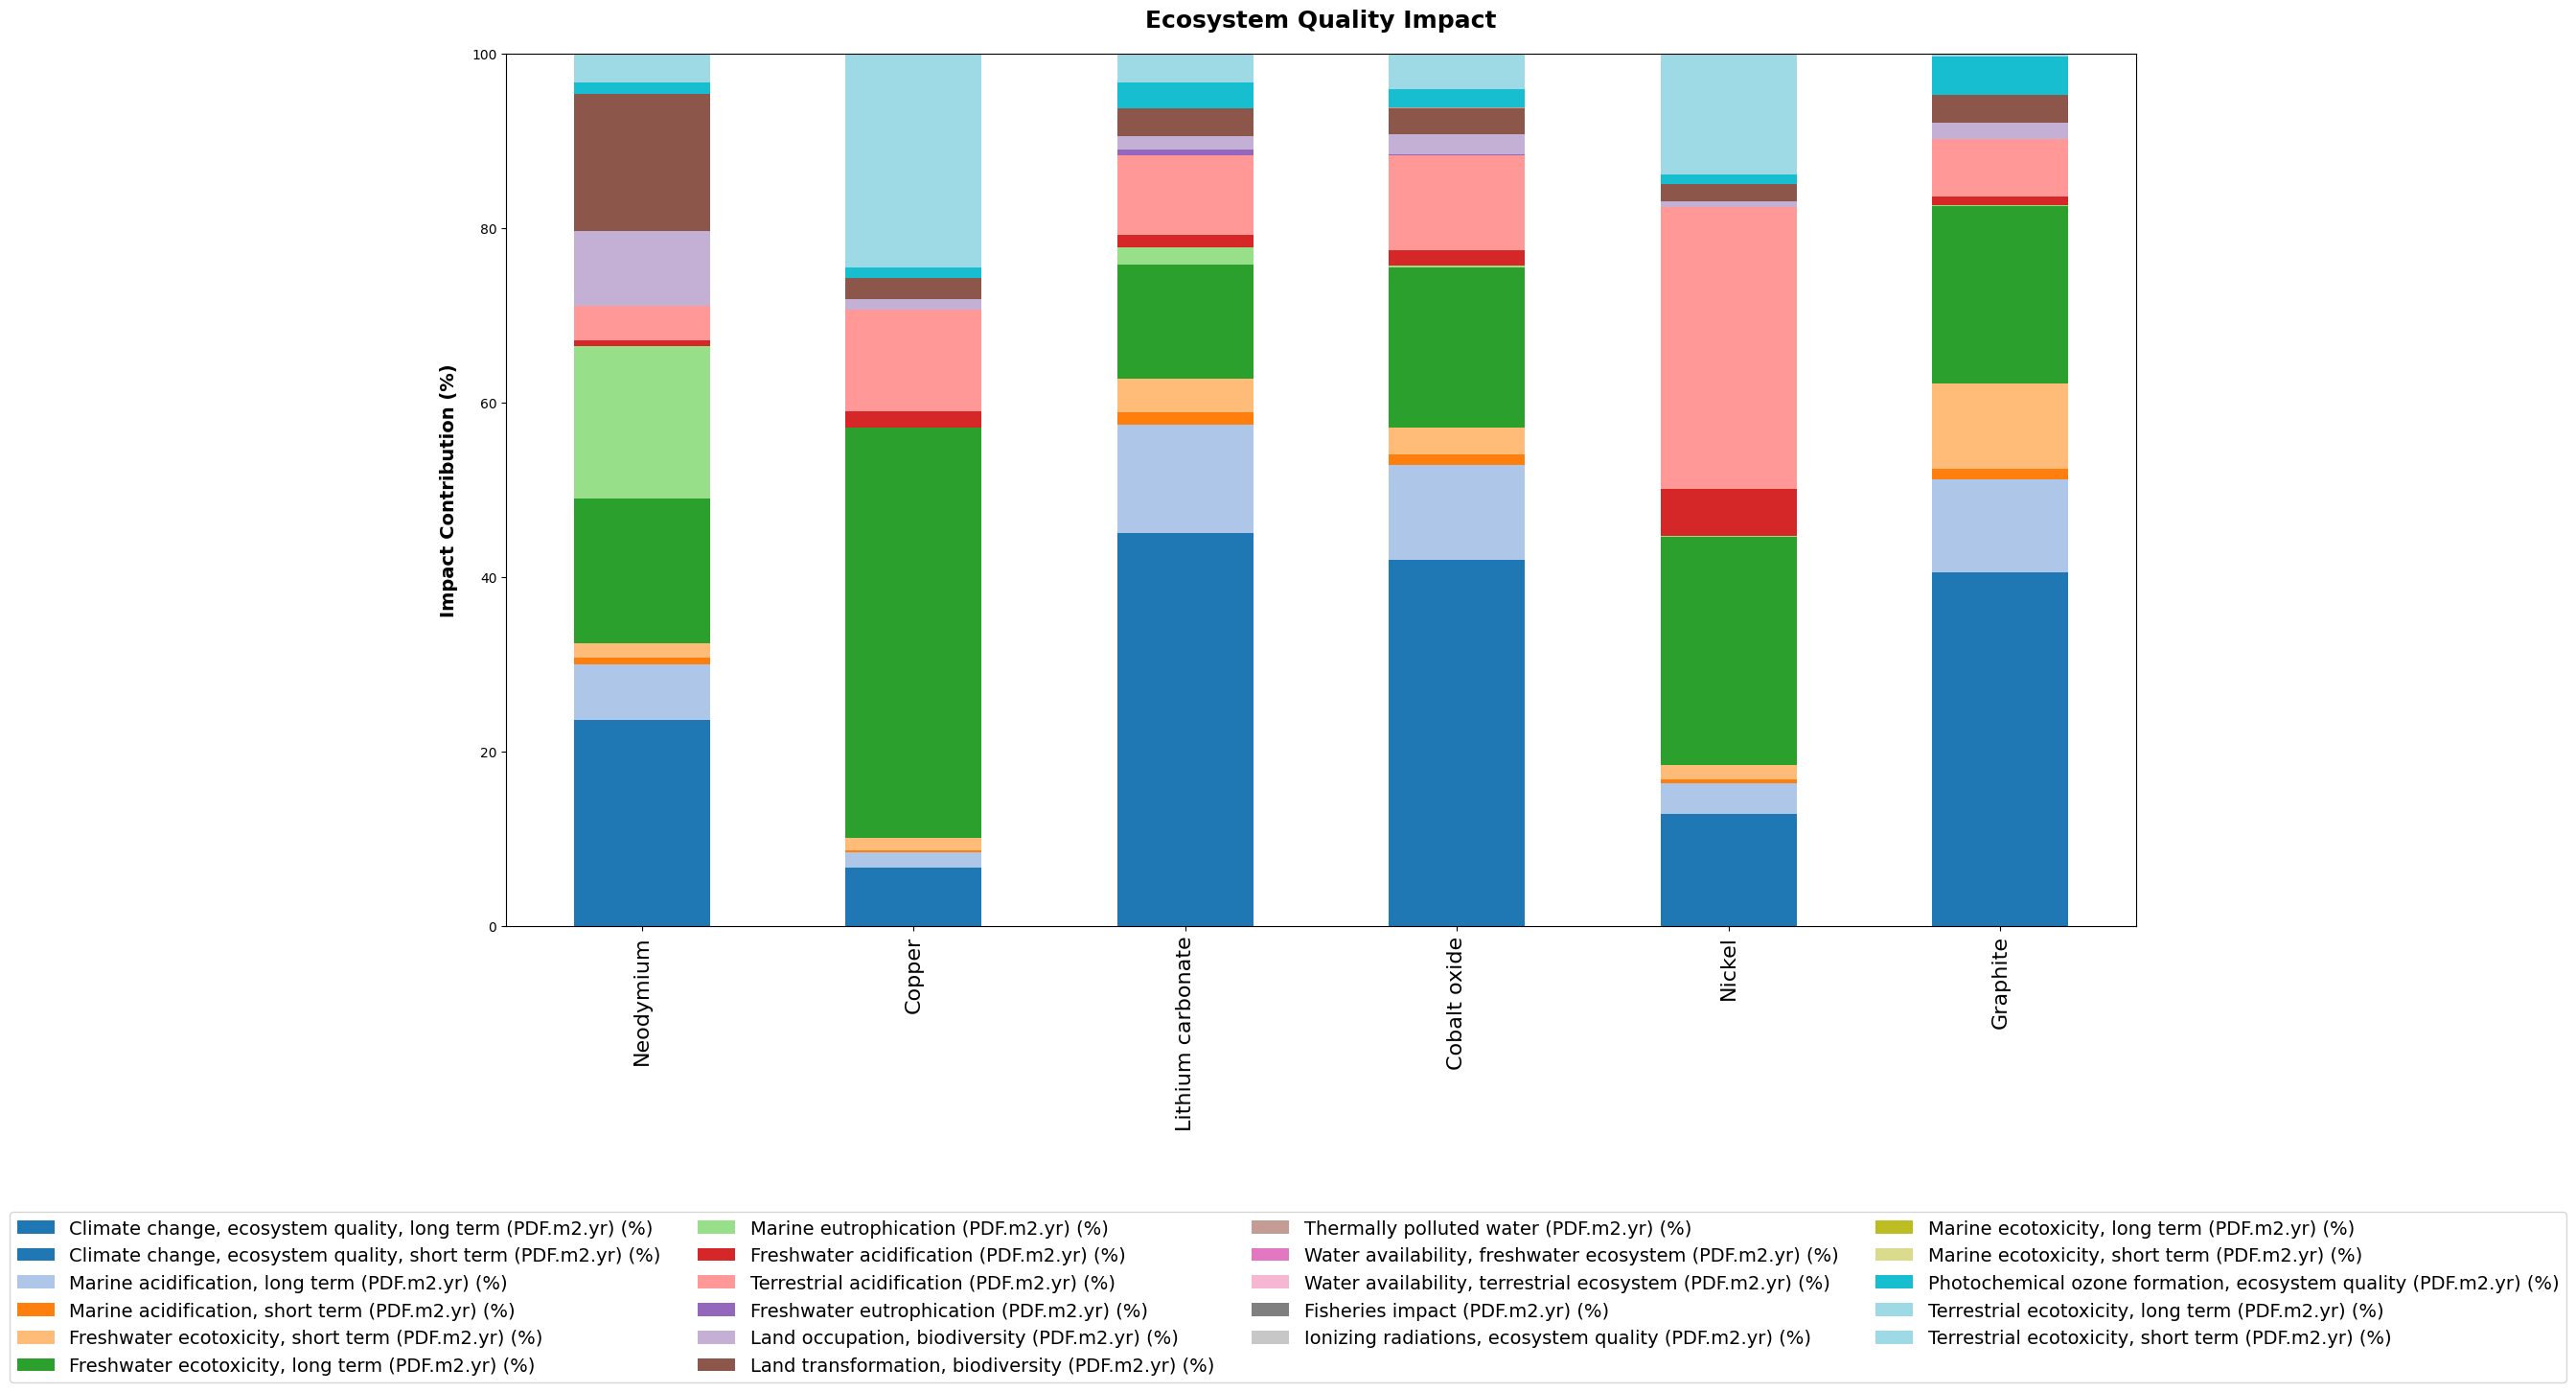

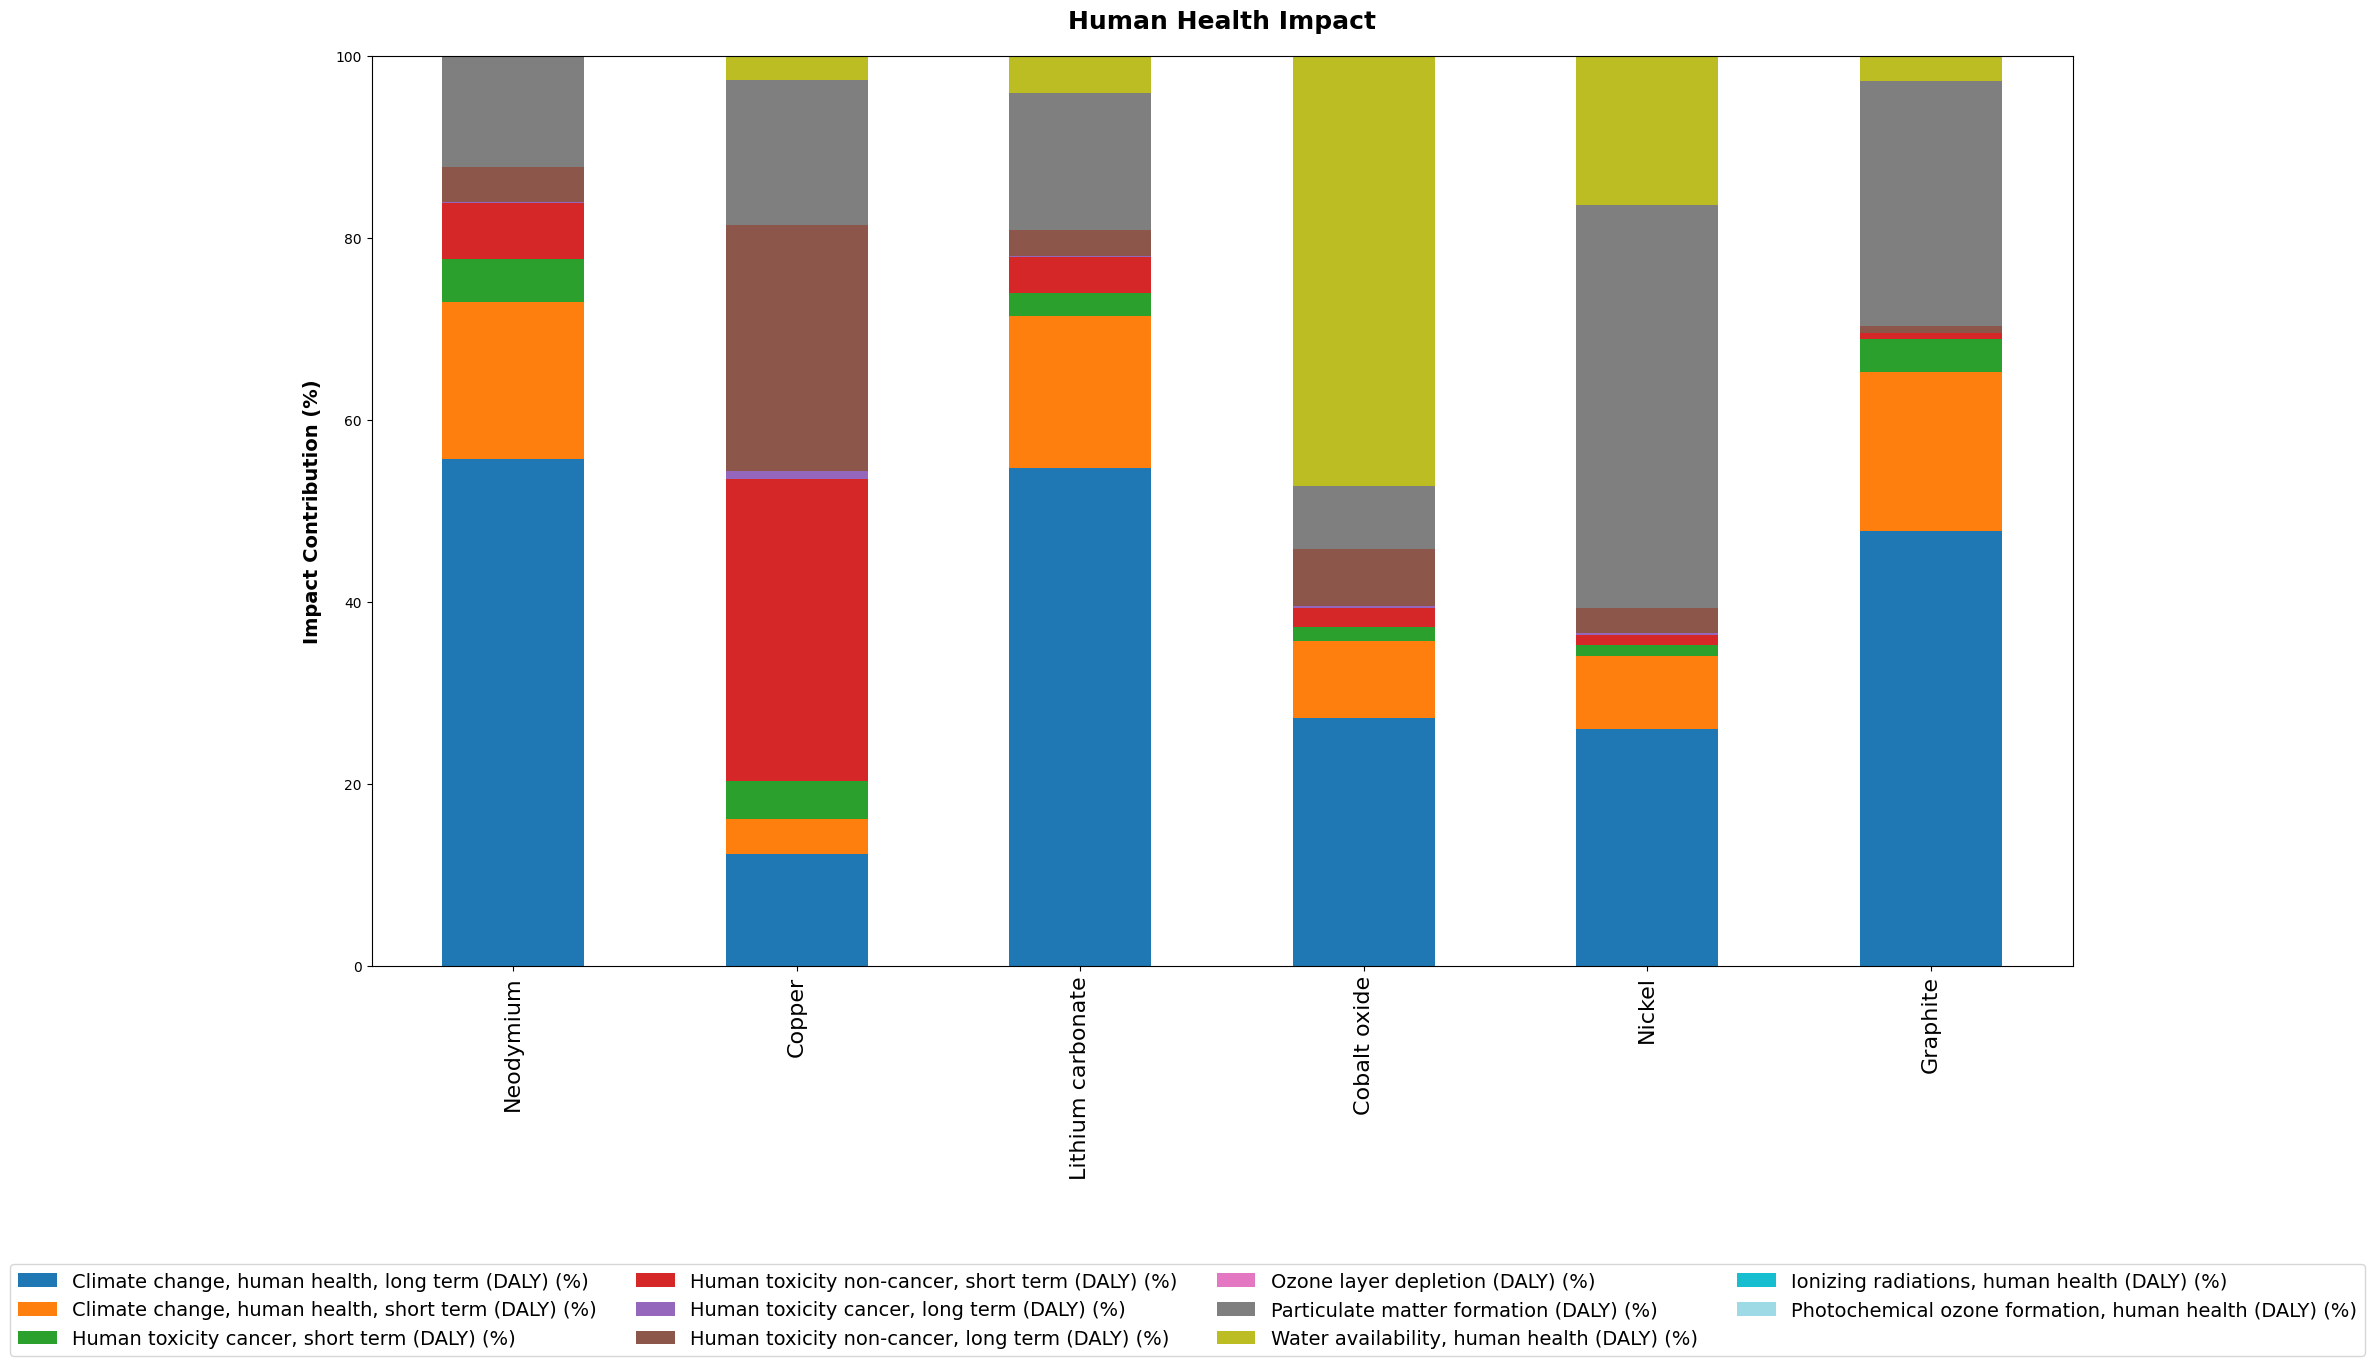

In [73]:
plot_iwplus_contributions(specific_lca_damage, save_path_eco="results/specific_lca_results/ecosystem_quality_contributions.png", save_path_hh="results/specific_lca_results/human_health_contributions.png")

# Calculate production-related impacts (e.g. scaled with scenarios)

## Import scenarios

They are from the Canadian Climate Institute and can be found [here](https://440megatonnes.ca/insight/canada-critical-minerals-clean-energy-transition/)

In [38]:
production_existing = pd.read_excel(r'data/scenarios_canadian_climate_institute.xlsx', sheet_name='Production_existing')
production_potential = pd.read_excel(r'data/scenarios_canadian_climate_institute.xlsx', sheet_name='Production_potential')
production_existing = production_existing[production_existing['Scenario']=='Domestic demand scenario']
production_potential = production_potential[production_potential['Scenario']=='Domestic demand scenario']

In [39]:
production_existing.rename(columns={'Mineral': 'Commodity'}, inplace=True)
production_potential.rename(columns={'Mineral': 'Commodity'}, inplace=True)

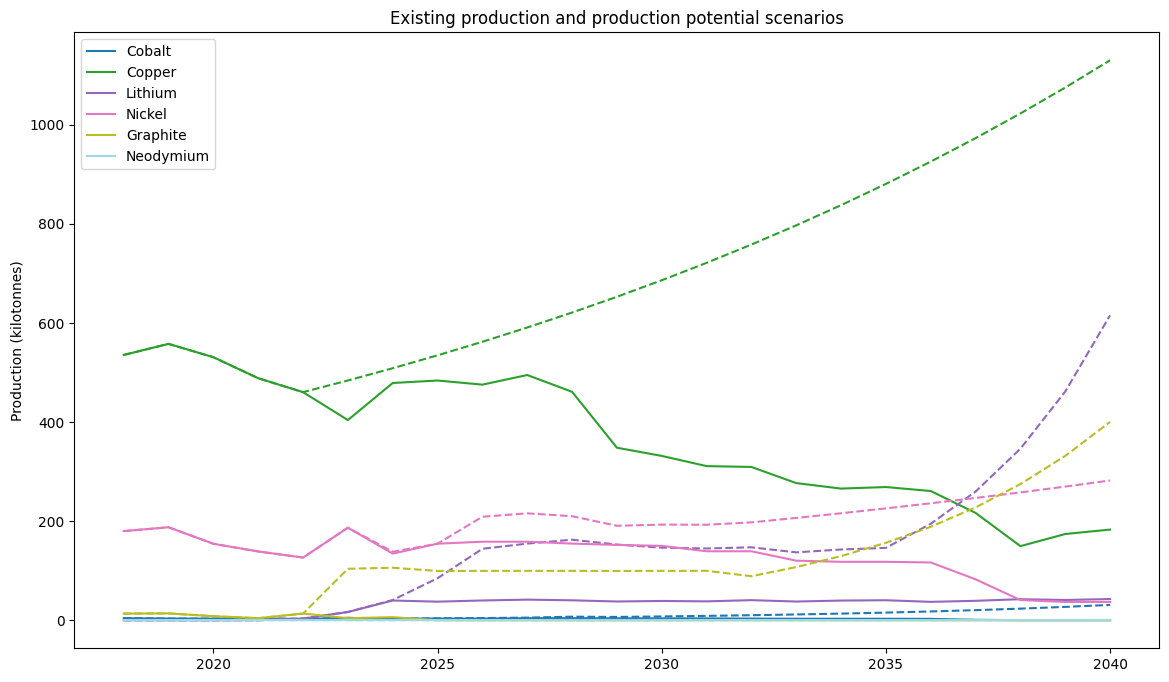

In [40]:
plot_scenario_production_comparison(production_existing, production_potential, save_path='results/demand_lca_results/cci_production_scenarios.png')

## Choose which LCI to associate with each mineral 

In [43]:
# Define a manual mapping to link the mineral in the scenario with the LCI of our choice
mineral_to_material_ei = {
    "Cobalt": "Cobalt oxide",
    "Copper": "Copper",
    "Lithium": "Lithium carbonate", 
    "Nickel": "Nickel",
    "Graphite": "Graphite",
    "Neodymium": "Neodymium"  
}


In [44]:
# Define a manual mapping to link the mineral in the scenario with the LCI of our choice
mineral_to_material_ri = {
    "Cobalt": "Cobalt oxide",
    "Copper": "Copper",
    "Lithium": "Lithium carbonate", 
    "Nickel": "Nickel",
    "Graphite": "Graphite",
    "Neodymium": "Neodymium"  
}

## Calculate the production-related impacts of scenarios

In [45]:
# With EI
projected_impacts_existing_production_ei = calculate_projected_impacts(production_existing, specific_lca_ei, mineral_to_material_ei)
projected_impacts_potential_production_ei = calculate_projected_impacts(production_potential, specific_lca_ei, mineral_to_material_ei)


In [46]:
# With Regioinvent
projected_impacts_existing_production_ri = calculate_projected_impacts(production_existing, specific_lca_ri,
                                                                       mineral_to_material_ri)
projected_impacts_potential_production_ri = calculate_projected_impacts(production_potential, specific_lca_ri,
                                                                        mineral_to_material_ri)


In [48]:
projected_impacts_existing_production_ri

,Year,Commodity,Total human health (DALY),Total ecosystem quality (PDF.m2.yr)
0,2018,Cobalt,4154.859725,1.805094e+08
1,2019,Cobalt,3448.570739,1.498244e+08
2,2020,Cobalt,3251.002694,1.412410e+08
3,2021,Cobalt,3825.931572,1.662190e+08
4,2022,Cobalt,2547.645948,1.106834e+08
...,...,...,...,...
133,2036,Neodymium,0.000000,0.000000e+00
134,2037,Neodymium,0.000000,0.000000e+00
135,2038,Neodymium,0.000000,0.000000e+00
136,2039,Neodymium,0.000000,0.000000e+00


In [49]:
impact_categories = [
#'Climate change ST (kg CO2 eq)',
'Total human health (DALY)',
'Total ecosystem quality (PDF.m2.yr)'    
]

In [56]:
import matplotlib.pyplot as plt

In [83]:
# Plot impacts per production scenario
plot_production_impacts(projected_impacts_existing_production_ei, production_existing, 
                             impact_categories, 
                             scenario_name='existing_production',
                            lci_used='EI')
plot_production_impacts(projected_impacts_potential_production_ei, production_potential, 
                             impact_categories, scenario_name='potential_production',
                        lci_used='EI')


Combined plot saved to results/demand_lca_results\combined_impact_existing_production_EI.png
Combined plot saved to results/demand_lca_results\combined_impact_potential_production_EI.png


In [84]:
# Plot impacts per production scenario
plot_production_impacts(projected_impacts_existing_production_ri, production_existing, 
                             impact_categories, 
                             scenario_name='existing_production',
                             lci_used='Regioinvent')
plot_production_impacts(projected_impacts_potential_production_ri, production_potential, 
                             impact_categories, 
                        scenario_name='potential_production',
                        lci_used='Regioinvent')

Combined plot saved to results/demand_lca_results\combined_impact_existing_production_Regioinvent.png
Combined plot saved to results/demand_lca_results\combined_impact_potential_production_Regioinvent.png
